In [ ]:
## Notebook env: brian_script_env (R kernel)

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
## get list of CO genes that came out as hits in q25/q75 + q10/q90 analysis
z_melt_ordered_q75 = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_original/z_melt_ordered_q25_q75.csv')
z_melt_ordered_q90 = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original/z_melt_ordered_q10_q90.csv')
z_melt_ordered = bind_rows('q25 vs q75' = z_melt_ordered_q75, 'q10 vs q90' = z_melt_ordered_q90, .id = 'group')
z_melt_ordered = z_melt_ordered %>% select(-X)
z_melt_ordered$group <- factor(z_melt_ordered$group, levels = c('q25 vs q75', 'q10 vs q90'))
z_melt_ordered_filtered = z_melt_ordered[z_melt_ordered$value > 2.5,]
intersected_genes_z2.5 = intersect(z_melt_ordered_filtered[z_melt_ordered_filtered$group == 'q25 vs q75', 'Chromatin.factor.name'], z_melt_ordered_filtered[z_melt_ordered_filtered$group == 'q10 vs q90', 'Chromatin.factor.name'])

CO_genes_interesected = as.character(intersected_genes_z2.5)
CO_genes_q25_q75 = as.character(z_melt_ordered_filtered[z_melt_ordered_filtered$group == 'q25 vs q75', 'Chromatin.factor.name'])
CO_genes_q10_q90 = as.character(z_melt_ordered_filtered[z_melt_ordered_filtered$group == 'q10 vs q90', 'Chromatin.factor.name'])


## load in expression data
CNA_data <- read.csv("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_CNA.txt", header = TRUE, sep = "\t")
RNA_Seq_expression_raw_data <- read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## q25 vs q75 ##

### CNA mean values ###

In [3]:
RNA_Seq_expression_raw_data_total = RNA_Seq_expression_raw_data %>% filter(Hugo_Symbol %in% CO_genes_q25_q75) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
patient_groupings = RNA_Seq_expression_raw_data_total %>% group_by(Hugo_Symbol) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .25)) ~ 'q25', if_all(Expression, function(x) x >= quantile(x, .75)) ~ 'q75', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

patients_not_in_CNA_data = setdiff(colnames(RNA_Seq_expression_raw_data), colnames(CNA_data))
patient_groupings = patient_groupings %>% filter(!Patient %in% patients_not_in_CNA_data)

patient_grouping_list = patient_groupings %>% select(-Expression) %>% pivot_wider(names_from = Hugo_Symbol, values_from = Patient)
q25_patients_list = lapply(patient_grouping_list[-1], '[[', 1)
names(q25_patients_list) = names(patient_grouping_list)[-1]

q75_patients_list = lapply(patient_grouping_list[-1], '[[', 2)
names(q75_patients_list) = names(patient_grouping_list)[-1]

Warning message:
“Values are not uniquely identified; output will contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = length` to identify where the duplicates arise
* Use `values_fn = {summary_fun}` to summarise duplicates”


In [5]:
plot_df = list()
plots = list()
for (i in 1:length(CO_genes_q25_q75)){
    gene = CO_genes_q25_q75[i]
    q25_CNA = CNA_data[, q25_patients_list[[gene]]]
    q75_CNA = CNA_data[, q75_patients_list[[gene]]]
    df = data.frame(q25 = rowMeans(q25_CNA), q75 = rowMeans(q75_CNA))
    plot_df[[i]] = df %>% pivot_longer(everything(), names_to = 'quartile', values_to = 'CNA') 
    plots[[i]] = ggplot(plot_df[[i]], aes(x = quartile, y = CNA)) + geom_boxplot() + ggtitle(gene) + stat_compare_means(paired = T) + xlab('') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))  
}

names(plot_df) = CO_genes_q25_q75

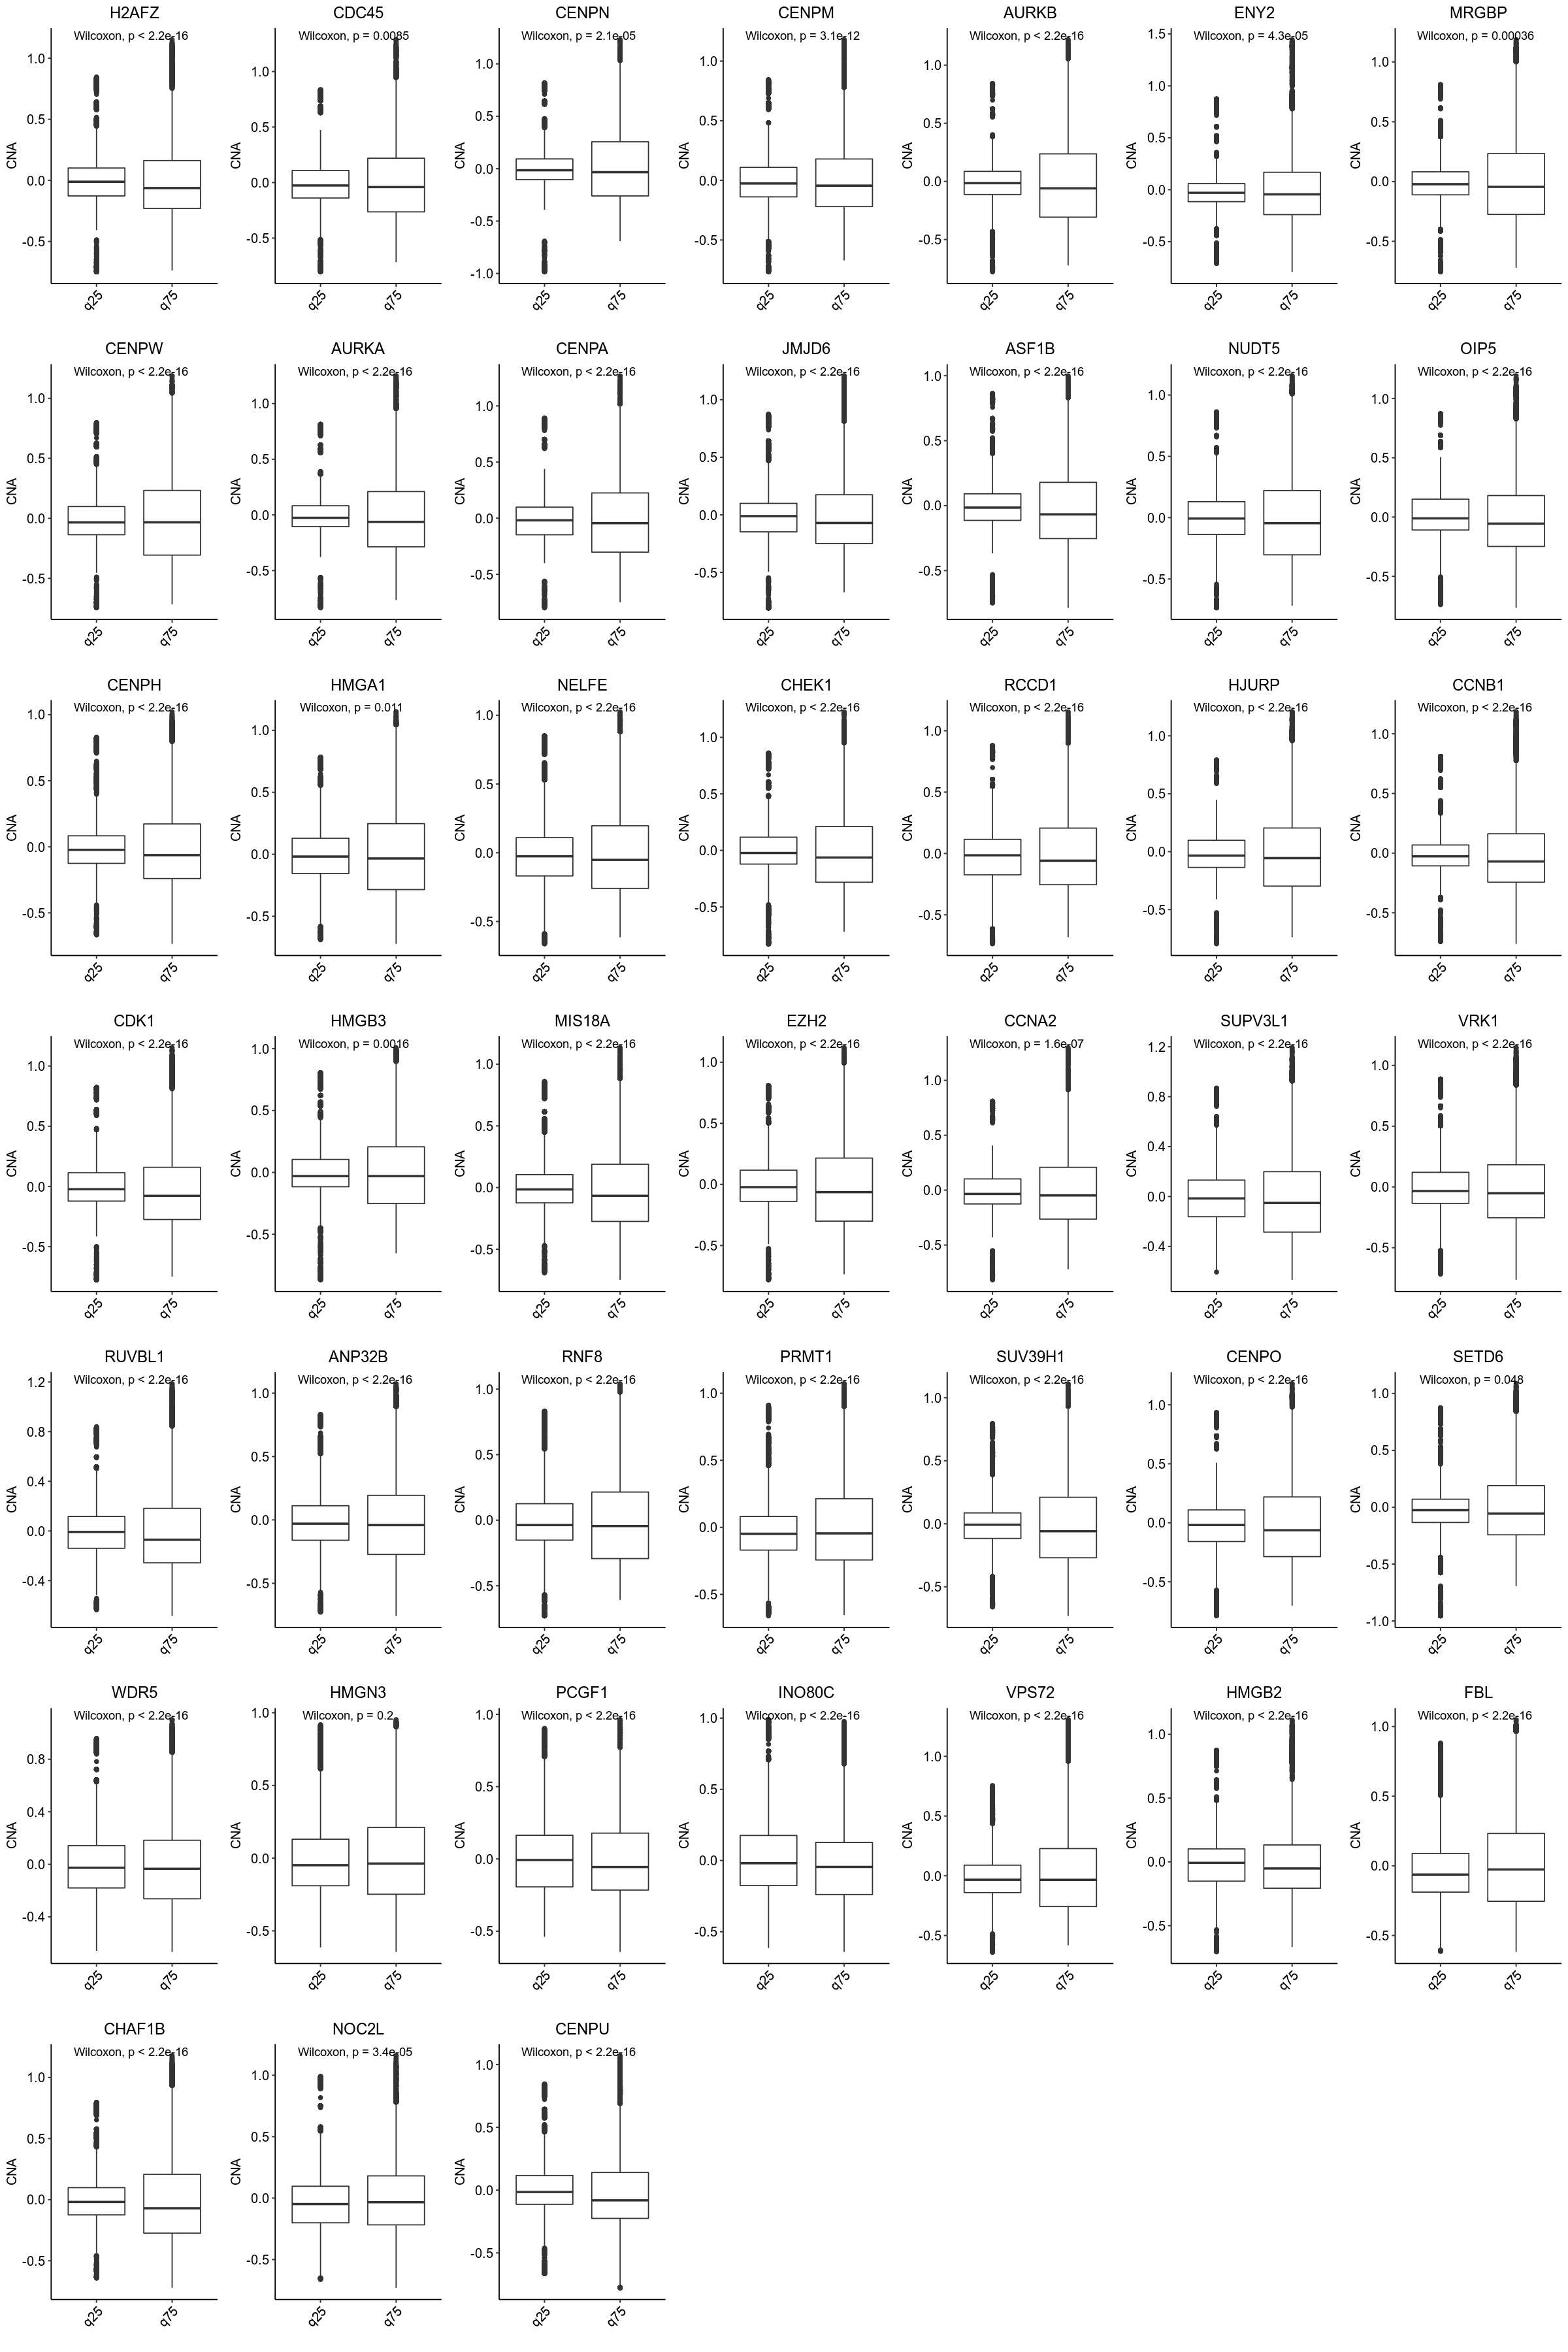

In [10]:
options(repr.plot.width = 20, repr.plot.height = 30)
ggarrange(plotlist = plots)

### CNA CV values ###

In [6]:
### does CV of CNA correlate with CV of gene expression between q25 and q75 for the COs?
CV = function(x) sd(x)/mean(x)
plot_df = list()
plots = list()
q75_q25_CNA_CV_ratios = list()

my_comparisons = list(c('q75', 'q25'))

for (i in 1:length(CO_genes_q25_q75)){
    gene = CO_genes_q25_q75[i]
    q25_CNA = CNA_data[, q25_patients_list[[gene]]]
    q75_CNA = CNA_data[, q75_patients_list[[gene]]]
    ## remove genes with means 0 from both q25 and q75
    select_rows = rowMeans(q25_CNA) != 0 & rowMeans(q75_CNA) != 0
    q25_CNA = q25_CNA[select_rows,]
    q75_CNA = q75_CNA[select_rows,]
    q25_CNA_CVs = apply(q25_CNA, 1, CV)
    q75_CNA_CVs = apply(q75_CNA, 1, CV)
    q75_q25_CNA_CV_ratios[[i]] = q75_CNA_CVs/q25_CNA_CVs
    df = data.frame(q25 = q25_CNA_CVs, q75 = q75_CNA_CVs)
    plot_df[[i]] = df %>% pivot_longer(everything(), names_to = 'quartile', values_to = 'CNA_CVs') 
    plots[[i]] = ggplot(plot_df[[i]], aes(x = quartile, y = CNA_CVs)) + geom_boxplot() + ggtitle(gene) + stat_compare_means(comparisons = my_comparisons, method.args = list(alternative = 'greater'),  paired = F) + xlab('') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))  
}

names(plot_df) = CO_genes_q25_q75
names(q75_q25_CNA_CV_ratios) = CO_genes_q25_q75

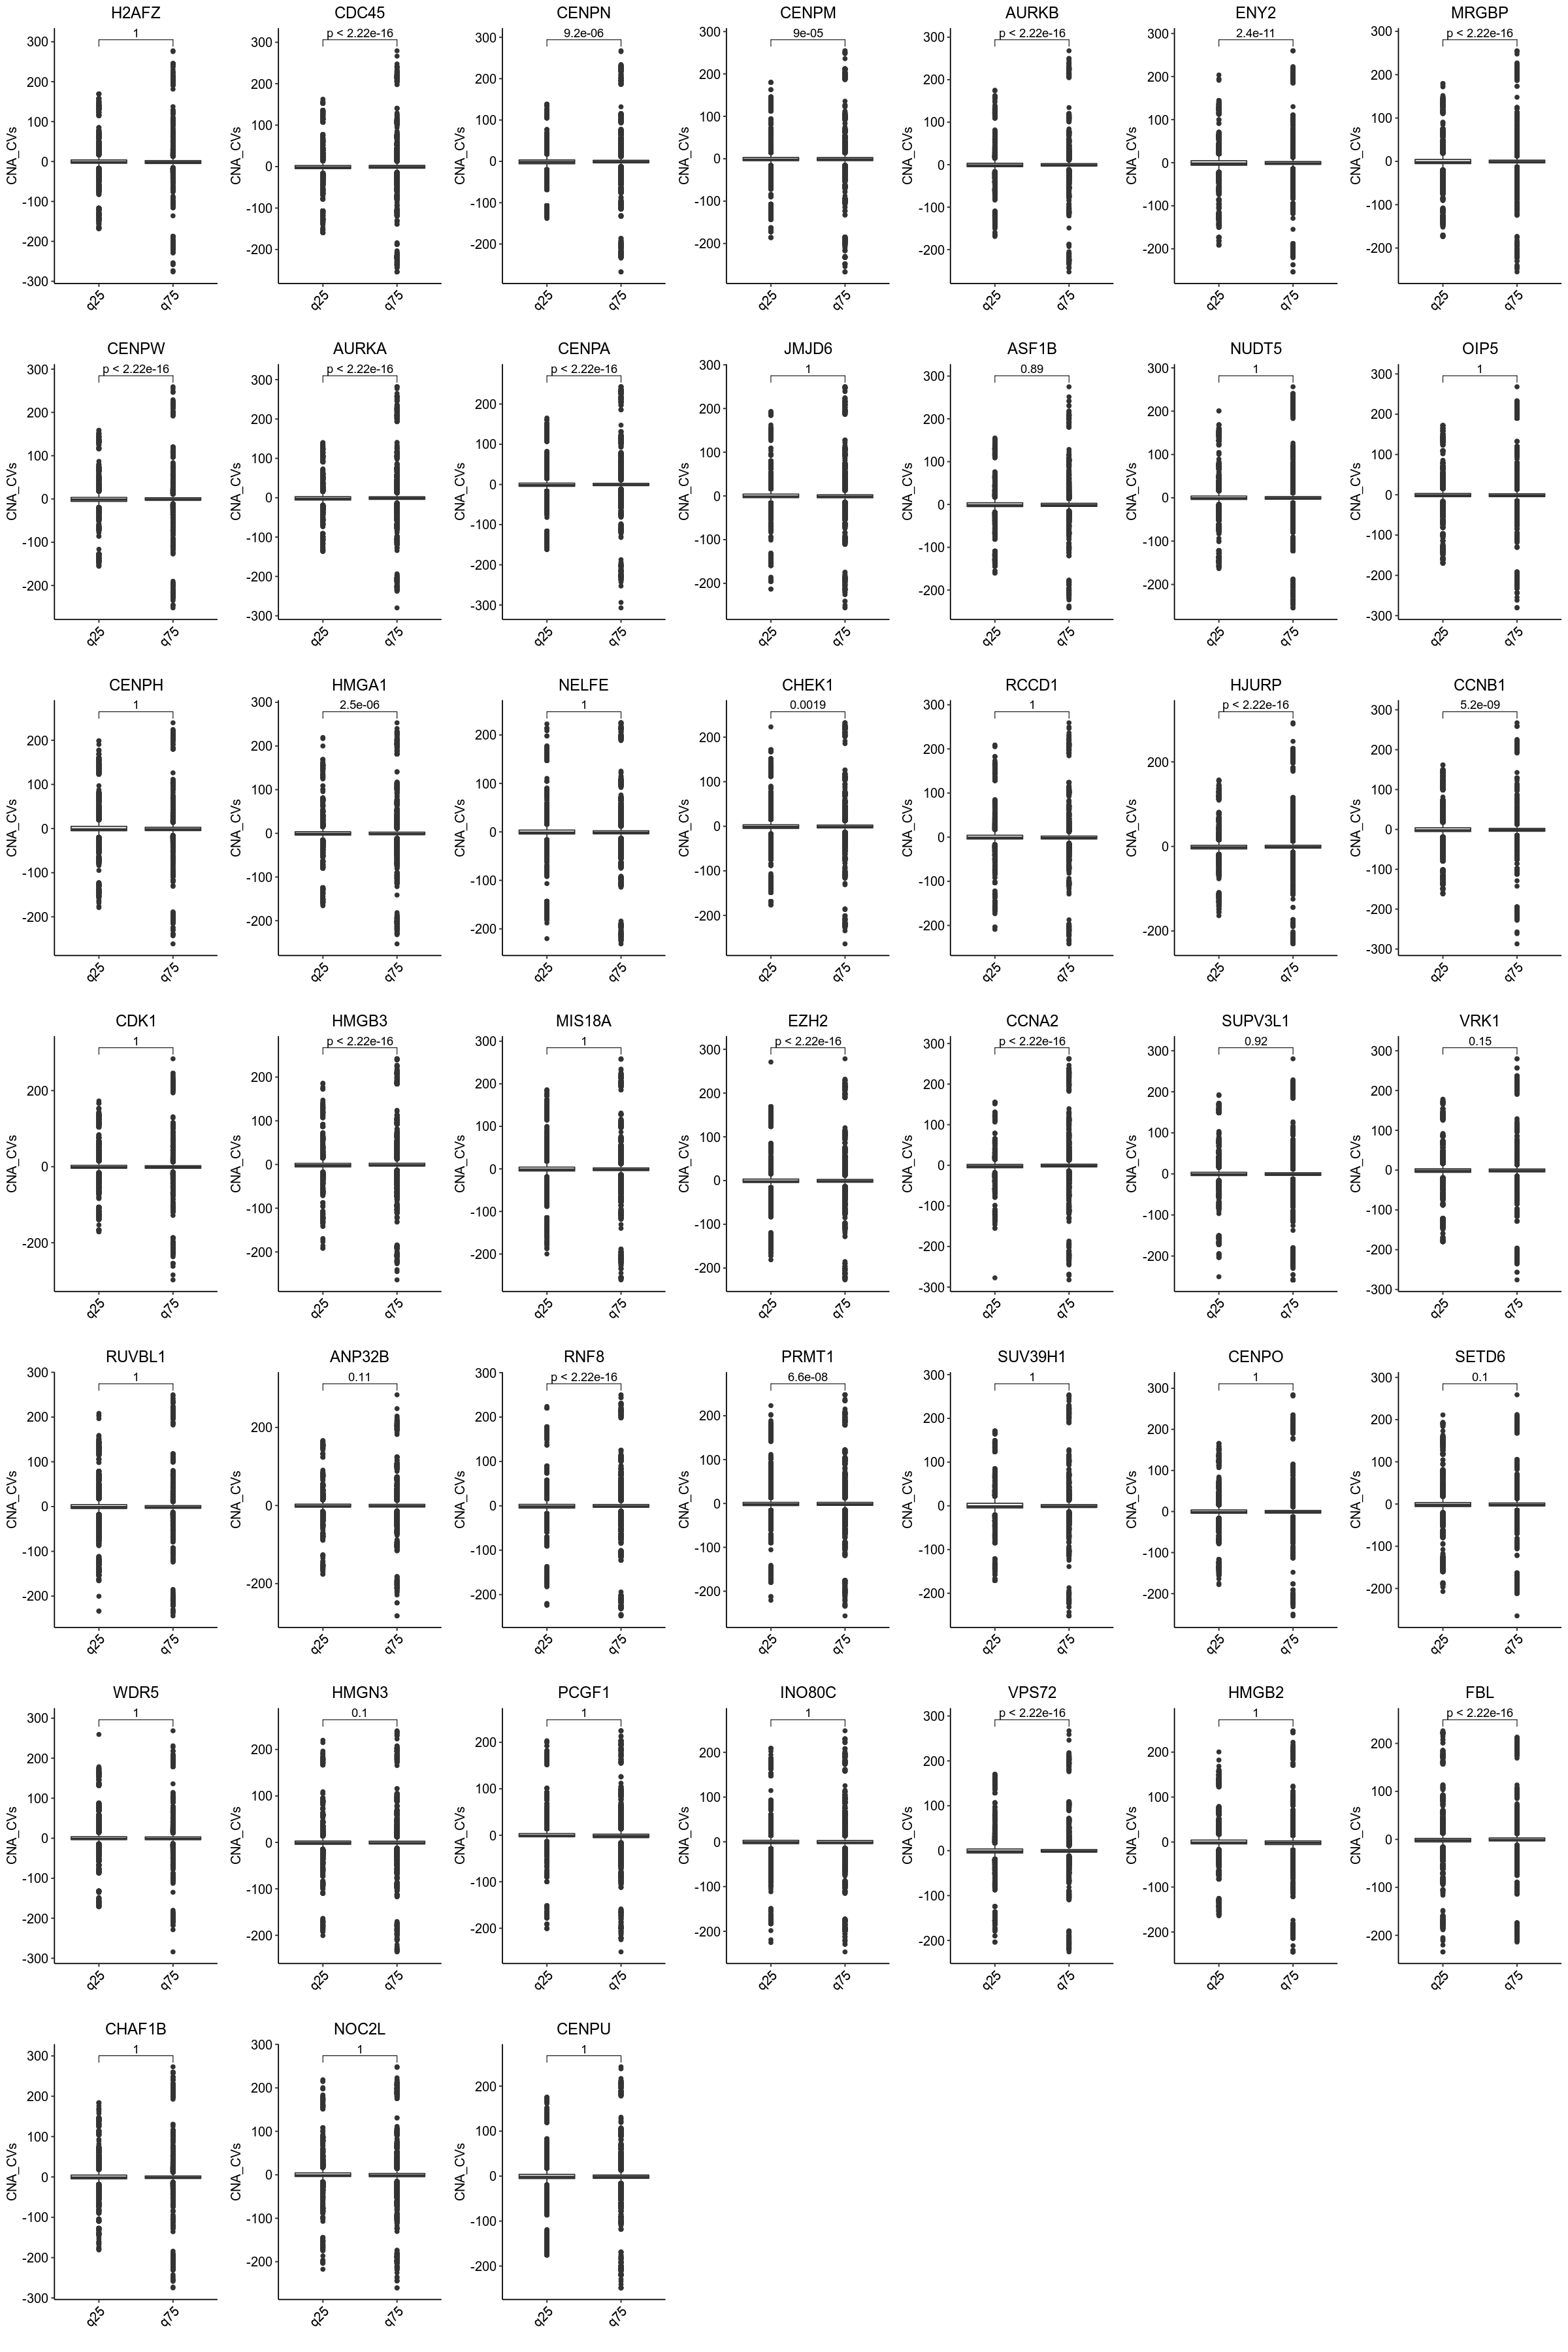

In [7]:
options(repr.plot.width = 20, repr.plot.height = 30)
ggarrange(plotlist = plots)

### Correlation of gene expression CV with CNA CV ###

In [8]:
## correlate gene expression CV q75/q25 genes ratio with CNA CV q75/q25 genes ratio
## do for all COs above
path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_original/'
load(paste0(path, 'gped_clean_df_CV_ratio_q25_q75.RData'))
grouped_dataframes_list_with_CV_ratio_cleaned_q25_q75 = grouped_dataframes_list_with_CV_ratio_cleaned
names(grouped_dataframes_list_with_CV_ratio_cleaned_q25_q75) = unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned_q25_q75, '[[', 1))
q25_q75_gene_exp_CVs_list = grouped_dataframes_list_with_CV_ratio_cleaned_q25_q75[CO_genes_q25_q75] ## 3rd element for each list items is q25, 4th element is q75

q75_q25_gene_exp_CVs = lapply(q25_q75_gene_exp_CVs_list, function(x) 1/x[[3]]$CV_ratio)
names(q75_q25_gene_exp_CVs) = CO_genes_q25_q75
q75_q25_gene_exp_gene_names = q25_q75_gene_exp_CVs_list[[1]][[3]]$Hugo_Symbol

q75_q25_CNA_gene_names = as.character(CNA_data$Hugo_Symbol) ## for q75_q25_CNA_CV_ratios



In [13]:
save(q75_q25_gene_exp_CVs, q75_q25_gene_exp_gene_names, q75_q25_CNA_gene_names, q75_q25_CNA_CV_ratios, file = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/CNA_analysis/q75_q25_gene_exp_CVs_and_CNA_CVs.RData')

In [2]:
load('/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/CNA_analysis/q75_q25_gene_exp_CVs_and_CNA_CVs.RData')

In [3]:
q75_q25_genes = intersect(q75_q25_gene_exp_gene_names, q75_q25_CNA_gene_names)
q75_q25_gene_exp_CVs_ordered = lapply(q75_q25_gene_exp_CVs, function(x) x[match(q75_q25_genes, q75_q25_gene_exp_gene_names)])
q75_q25_CNA_CV_ratios_ordered = lapply(q75_q25_CNA_CV_ratios, function(x) x[match(q75_q25_genes, q75_q25_CNA_gene_names)])
CO_genes_q25_q75 = names(q75_q25_gene_exp_CVs_ordered)

In [4]:
corr_df = list()
corr_plots = list()
for (i in 1:length(CO_genes_q25_q75)) {
    corr_df[[i]] = data.frame(gene_exp_CV_ratios = q75_q25_gene_exp_CVs_ordered[[i]], CNA_CV_ratios = q75_q25_CNA_CV_ratios_ordered[[i]])
    corr_plots[[i]] = corr_df[[i]] %>% ggplot(aes(x = gene_exp_CV_ratios, y = CNA_CV_ratios)) +
    geom_smooth(method = "lm", formula = y ~ x, se = F, color = 'black') + geom_point() + xlab('Gene Exp CV q75/q25 ratios') + ylab('CNA CV q75/q25 ratios') +
    stat_cor(aes(), method = "pearson") + theme_pubr() +  
    ggtitle(CO_genes_q25_q75[i]) + #ylim(-0.32, 0.32) + xlim(-0.32, 0.32) +
    theme(plot.title = element_text(hjust = 0.5))
}

names(corr_df) = CO_genes_q25_q75

In [6]:
RNF8_corr_df = corr_df[['RNF8']]
MIS18A_corr_df = corr_df[['MIS18A']]
saveRDS(RNF8_corr_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig1/RNF8_corr_df_q25_q75.RDS')
saveRDS(MIS18A_corr_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig1/MIS18A_corr_df_q25_q75.RDS')

Warning message:
“Removed 195 rows containing non-finite values (stat_smooth).”


Warning message:
“Removed 195 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 195 rows containing missing values (geom_point).”
Warning message:
“Removed 158 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 158 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 158 rows containing missing values (geom_point).”
Warning message:
“Removed 134 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 134 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”
Warning message:
“Removed 239 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 239 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 239 rows containing missing values (geom_point).”
Warning message:
“Removed 193 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 193 rows containing non-finite values (sta

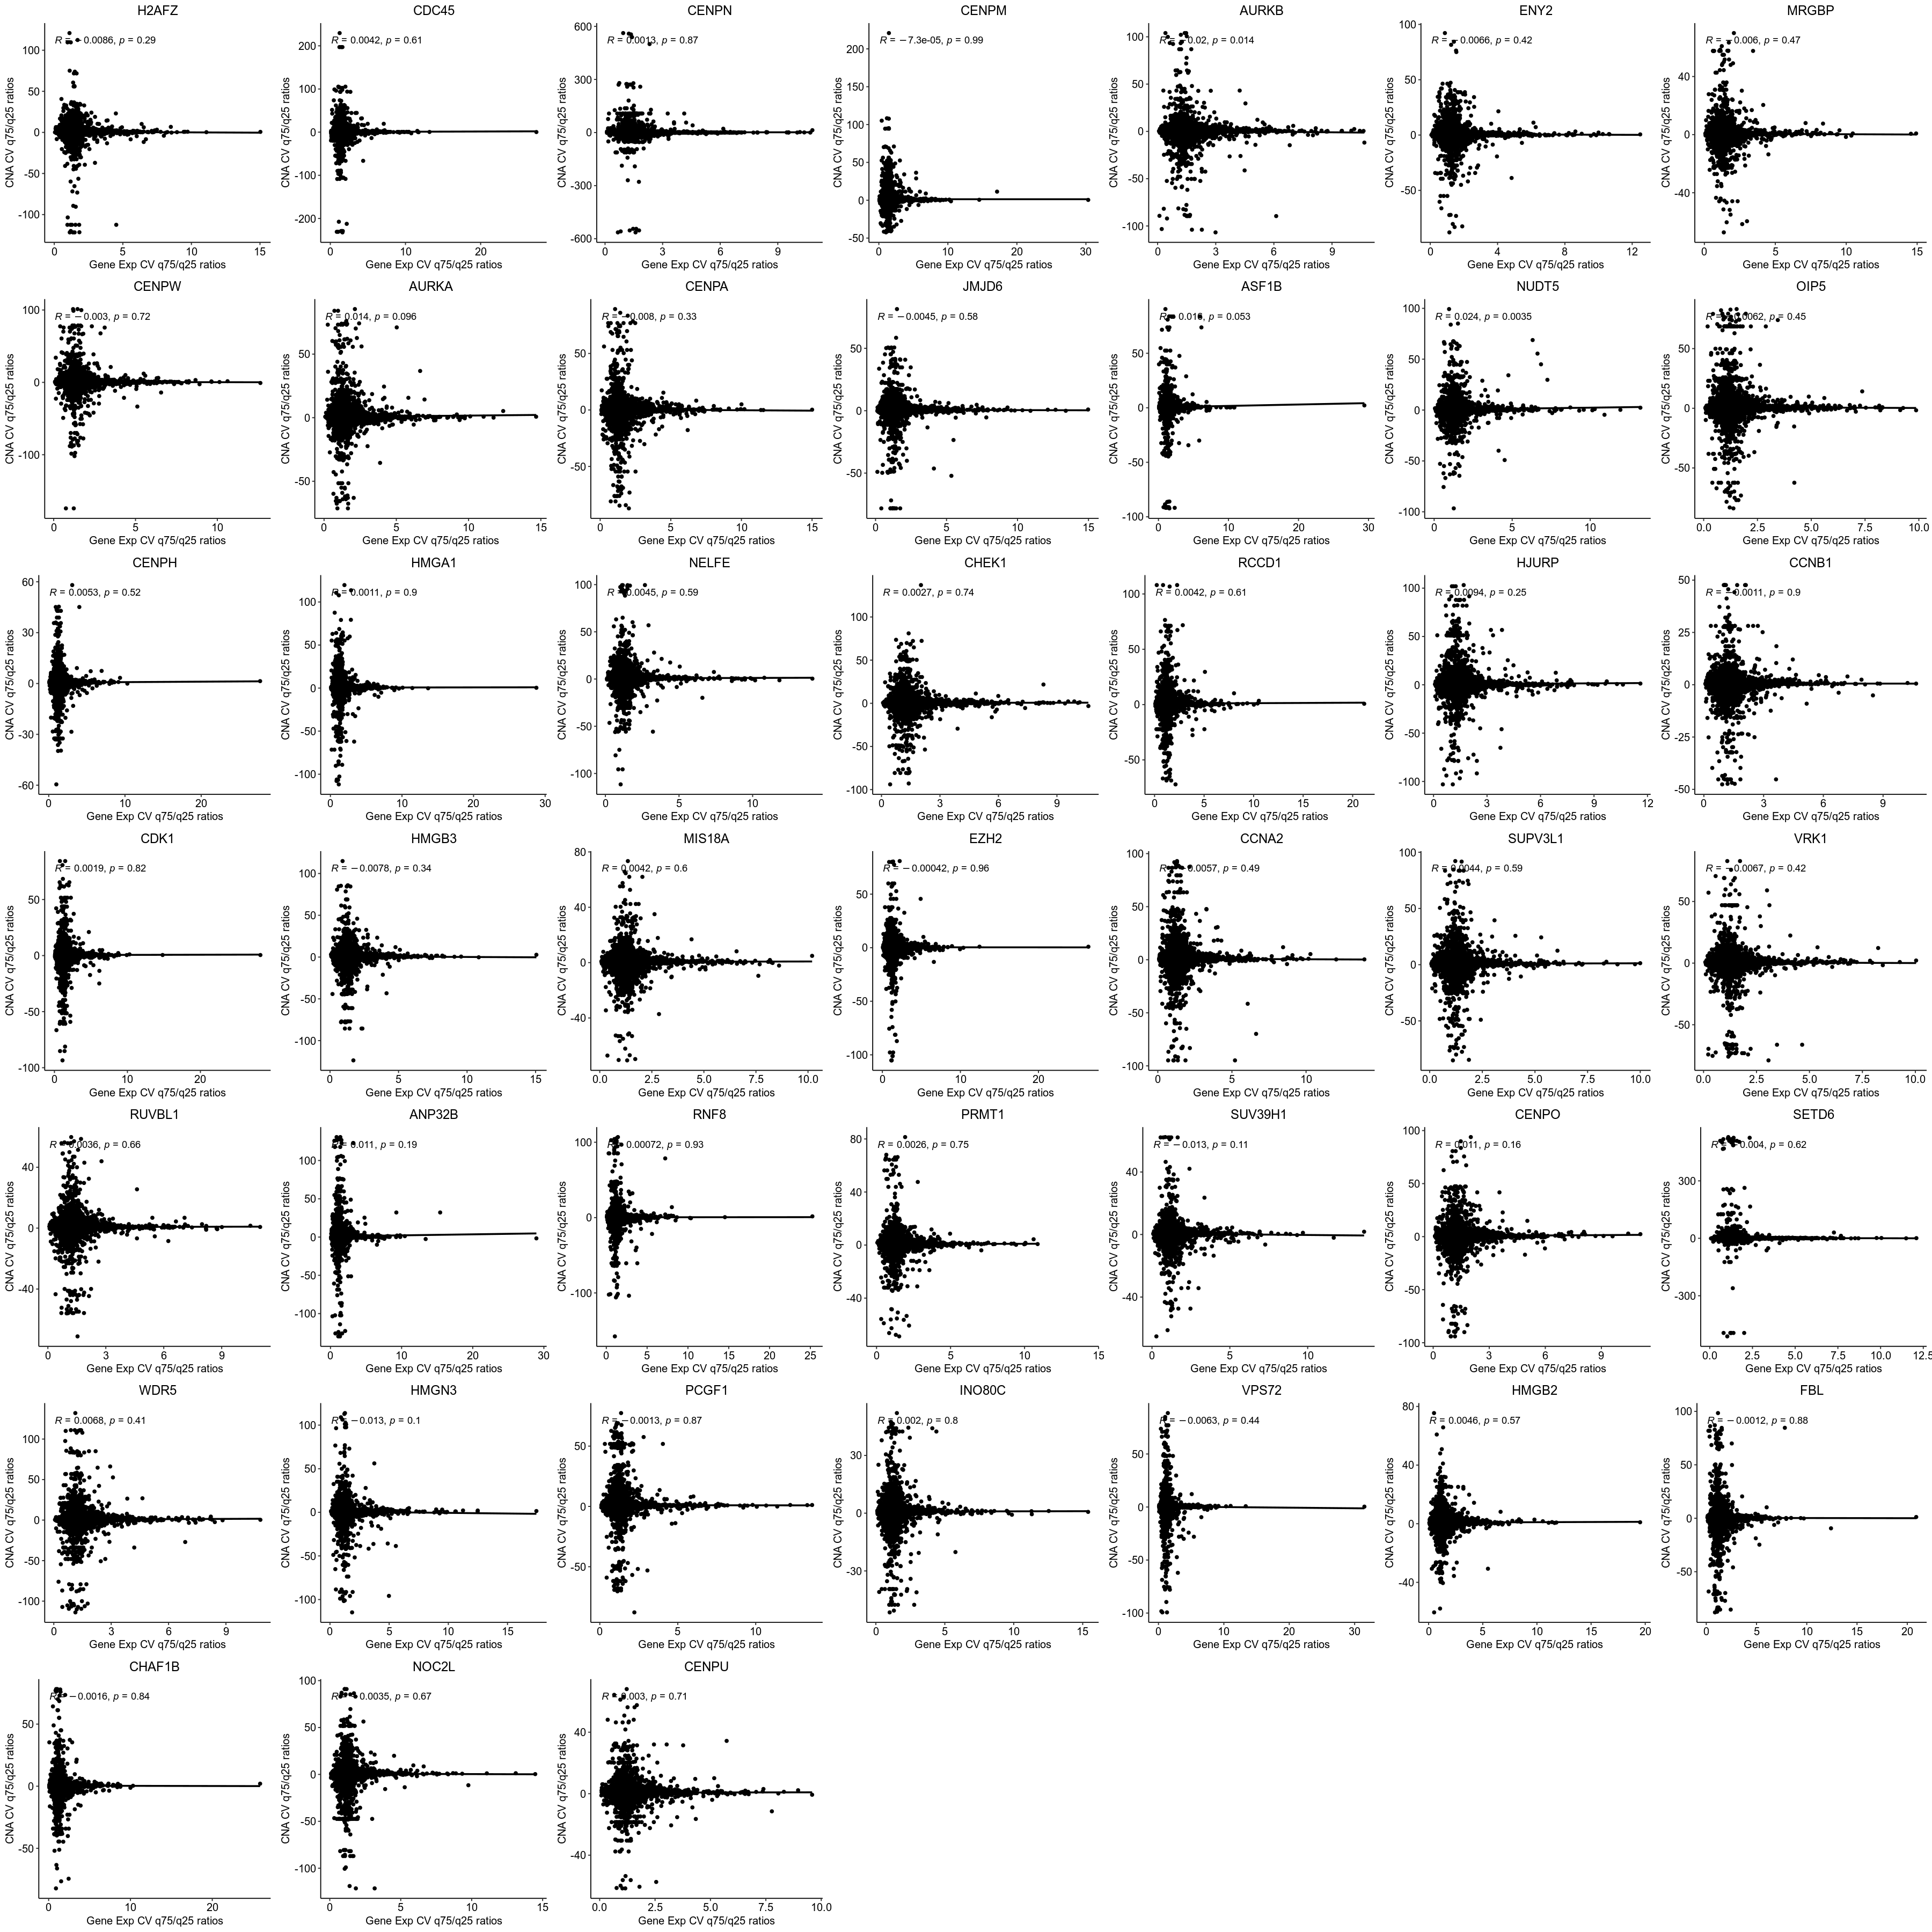

In [19]:
options(repr.plot.width = 30, repr.plot.height = 30)
ggarrange(plotlist = corr_plots)

## q10 vs q90 ##

### CNA mean values ###

In [3]:
RNA_Seq_expression_raw_data_total = RNA_Seq_expression_raw_data %>% filter(Hugo_Symbol %in% CO_genes_q10_q90) %>% select(-Entrez_Gene_Id) %>% group_by(Hugo_Symbol) %>% pivot_longer(-Hugo_Symbol, names_to = 'Patient', values_to = 'Expression')
patient_groupings = RNA_Seq_expression_raw_data_total %>% group_by(Hugo_Symbol) %>% mutate(quantile = case_when(if_all(Expression, function(x) x <= quantile(x, .10)) ~ 'q10', if_all(Expression, function(x) x >= quantile(x, .90)) ~ 'q90', TRUE ~ 'neither')) %>% filter(!quantile == 'neither')

patients_not_in_CNA_data = setdiff(colnames(RNA_Seq_expression_raw_data), colnames(CNA_data))
patient_groupings = patient_groupings %>% filter(!Patient %in% patients_not_in_CNA_data)

patient_grouping_list = patient_groupings %>% select(-Expression) %>% pivot_wider(names_from = Hugo_Symbol, values_from = Patient)
q10_patients_list = lapply(patient_grouping_list[-1], '[[', 1)
names(q10_patients_list) = names(patient_grouping_list)[-1]

q90_patients_list = lapply(patient_grouping_list[-1], '[[', 2)
names(q90_patients_list) = names(patient_grouping_list)[-1]

Warning message:
“Values are not uniquely identified; output will contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = length` to identify where the duplicates arise
* Use `values_fn = {summary_fun}` to summarise duplicates”


In [4]:
plot_df = list()
plots = list()
for (i in 1:length(CO_genes_q10_q90)){
    gene = CO_genes_q10_q90[i]
    q10_CNA = CNA_data[, q10_patients_list[[gene]]]
    q90_CNA = CNA_data[, q90_patients_list[[gene]]]
    df = data.frame(q10 = rowMeans(q10_CNA), q90 = rowMeans(q90_CNA))
    plot_df[[i]] = df %>% pivot_longer(everything(), names_to = 'quartile', values_to = 'CNA') 
    plots[[i]] = ggplot(plot_df[[i]], aes(x = quartile, y = CNA)) + geom_boxplot() + ggtitle(gene) + stat_compare_means(paired = T) + xlab('') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))  
}

names(plot_df) = CO_genes_q10_q90

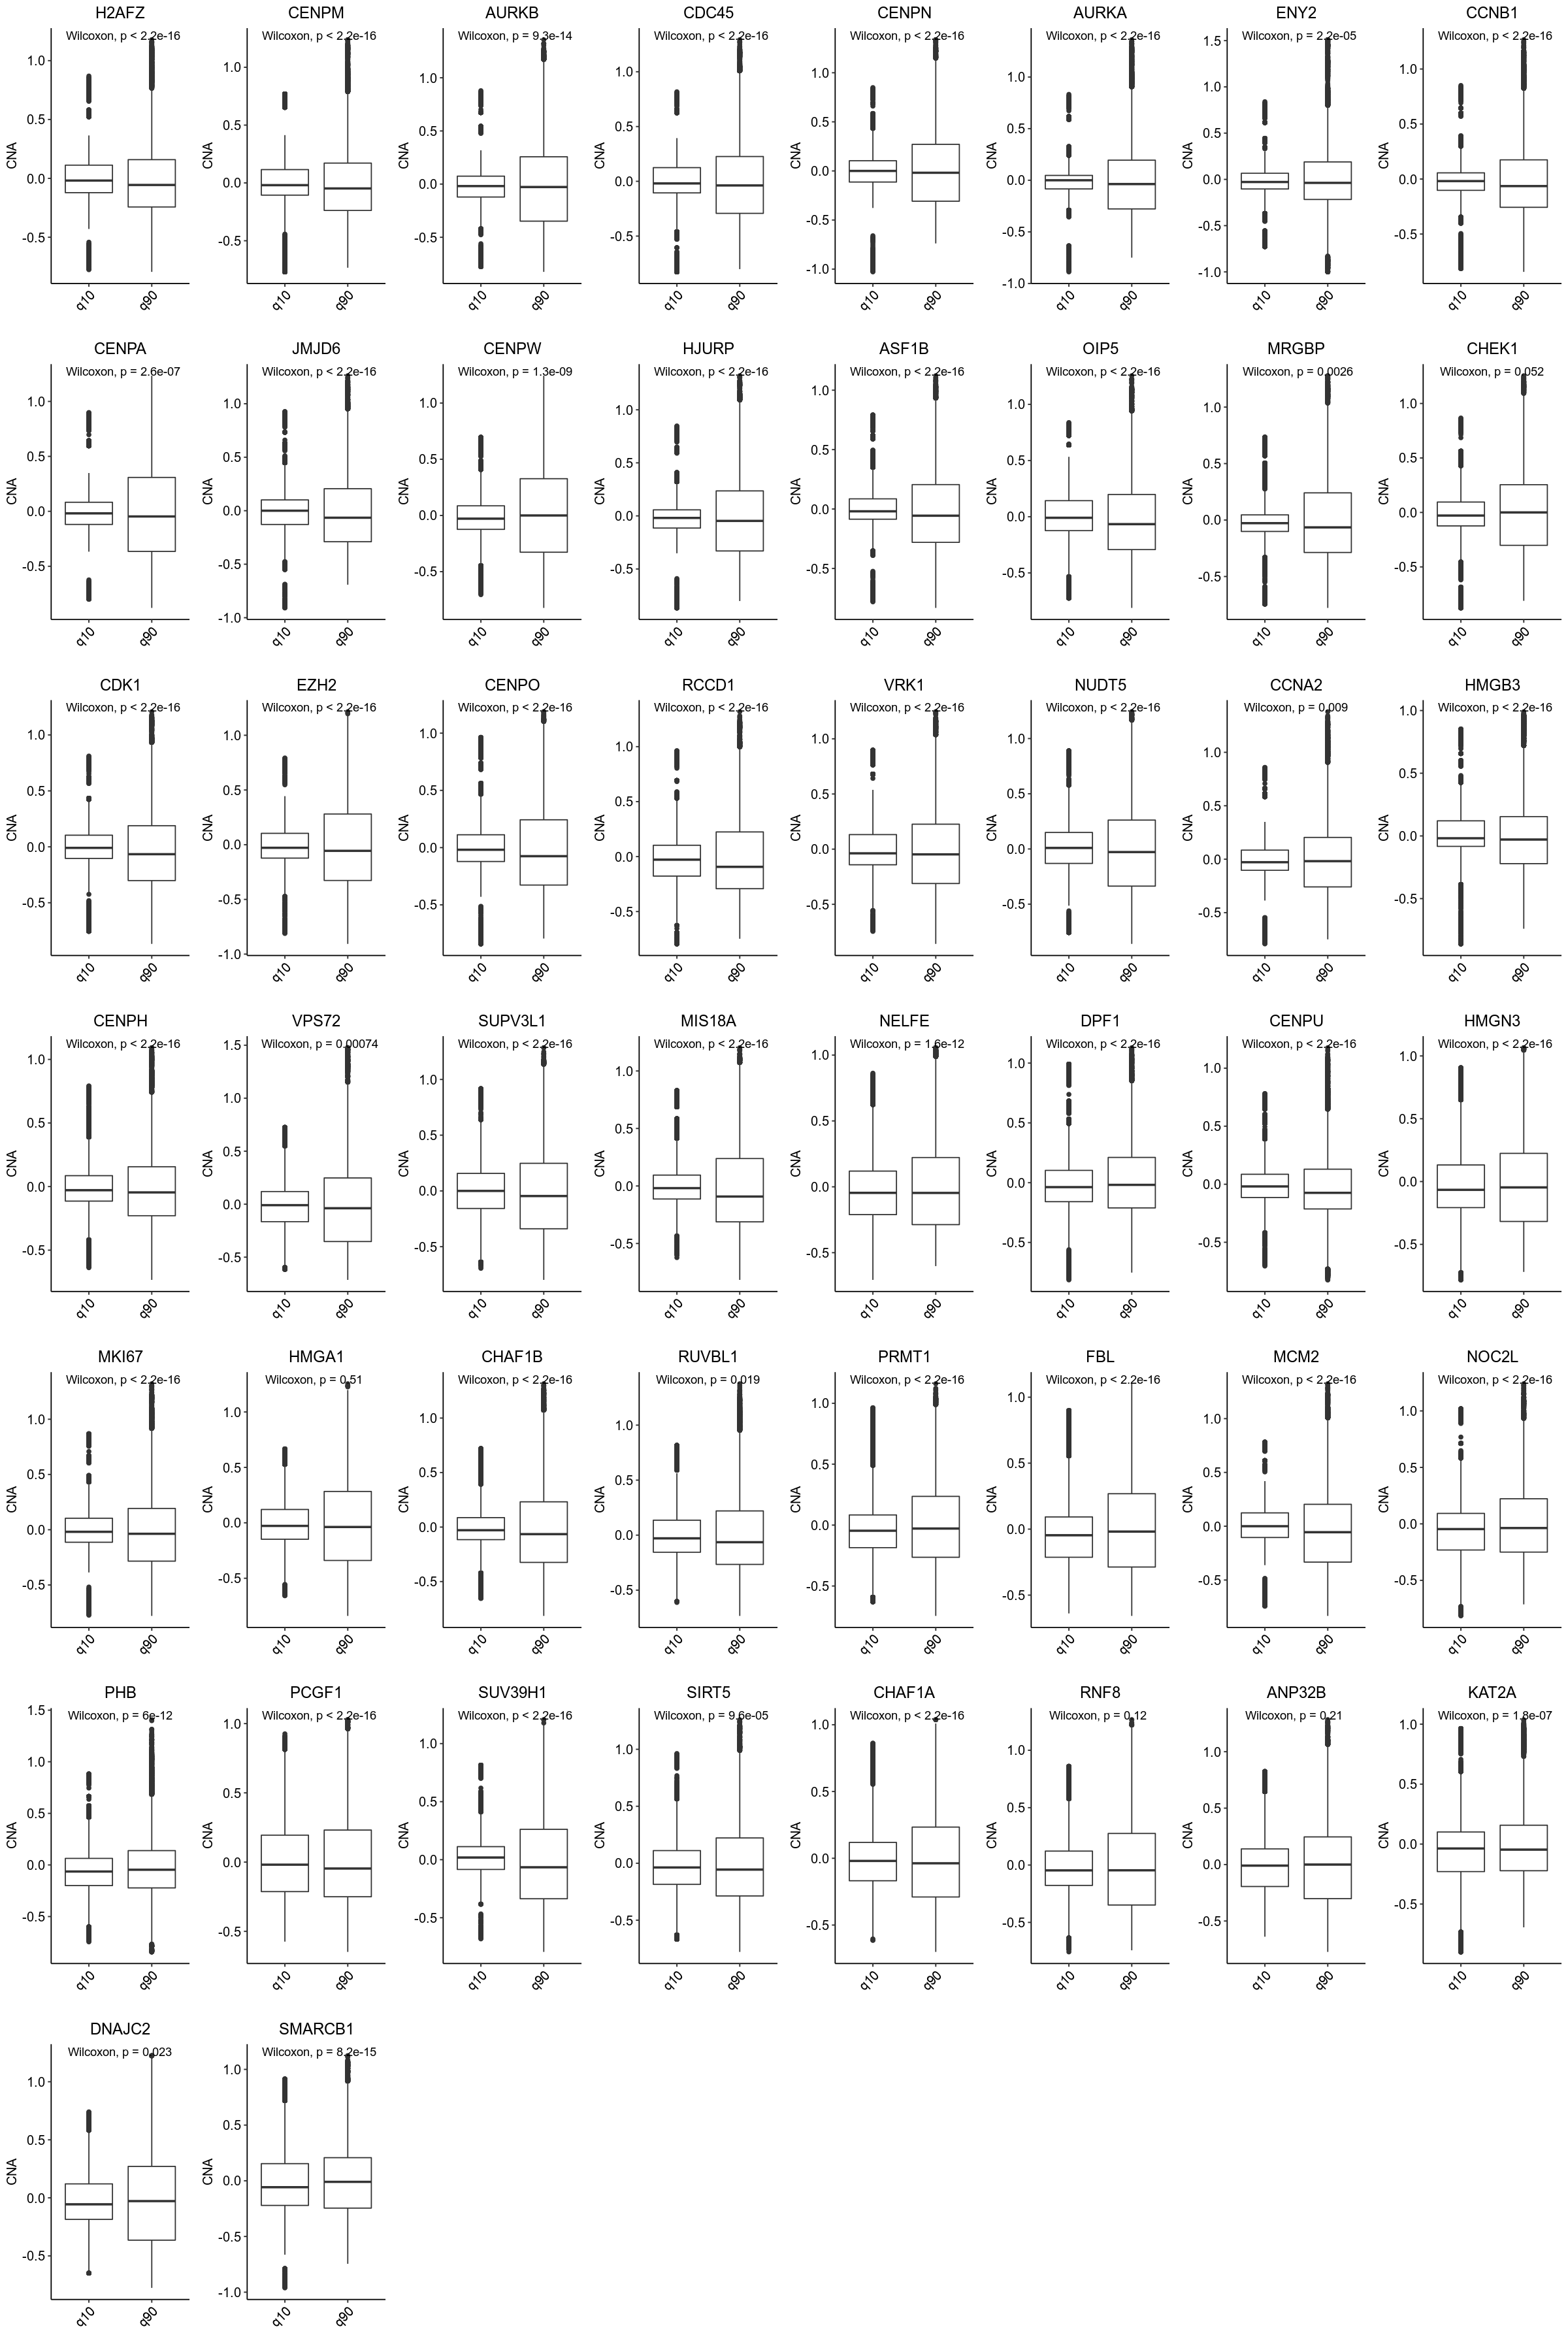

In [5]:
options(repr.plot.width = 20, repr.plot.height = 30)
ggarrange(plotlist = plots)

### CNA CV values ###

In [6]:
### does CV of CNA correlate with CV of gene expression between q10 and q90 for the COs?
CV = function(x) sd(x)/mean(x)
plot_df = list()
plots = list()
q90_q10_CNA_CV_ratios = list()

my_comparisons = list(c('q90', 'q10'))

for (i in 1:length(CO_genes_q10_q90)){
    gene = CO_genes_q10_q90[i]
    q10_CNA = CNA_data[, q10_patients_list[[gene]]]
    q90_CNA = CNA_data[, q90_patients_list[[gene]]]
    ## remove genes with means 0 from both q10 and q90
    select_rows = rowMeans(q10_CNA) != 0 & rowMeans(q90_CNA) != 0
    q10_CNA = q10_CNA[select_rows,]
    q90_CNA = q90_CNA[select_rows,]
    q10_CNA_CVs = apply(q10_CNA, 1, CV)
    q90_CNA_CVs = apply(q90_CNA, 1, CV)
    q90_q10_CNA_CV_ratios[[i]] = q90_CNA_CVs/q10_CNA_CVs
    df = data.frame(q10 = q10_CNA_CVs, q90 = q90_CNA_CVs)
    plot_df[[i]] = df %>% pivot_longer(everything(), names_to = 'quartile', values_to = 'CNA_CVs') 
    plots[[i]] = ggplot(plot_df[[i]], aes(x = quartile, y = CNA_CVs)) + geom_boxplot() + ggtitle(gene) + stat_compare_means(comparisons = my_comparisons, method.args = list(alternative = 'greater'),  paired = F) + xlab('') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))  
}

names(plot_df) = CO_genes_q10_q90
names(q90_q10_CNA_CV_ratios) = CO_genes_q10_q90

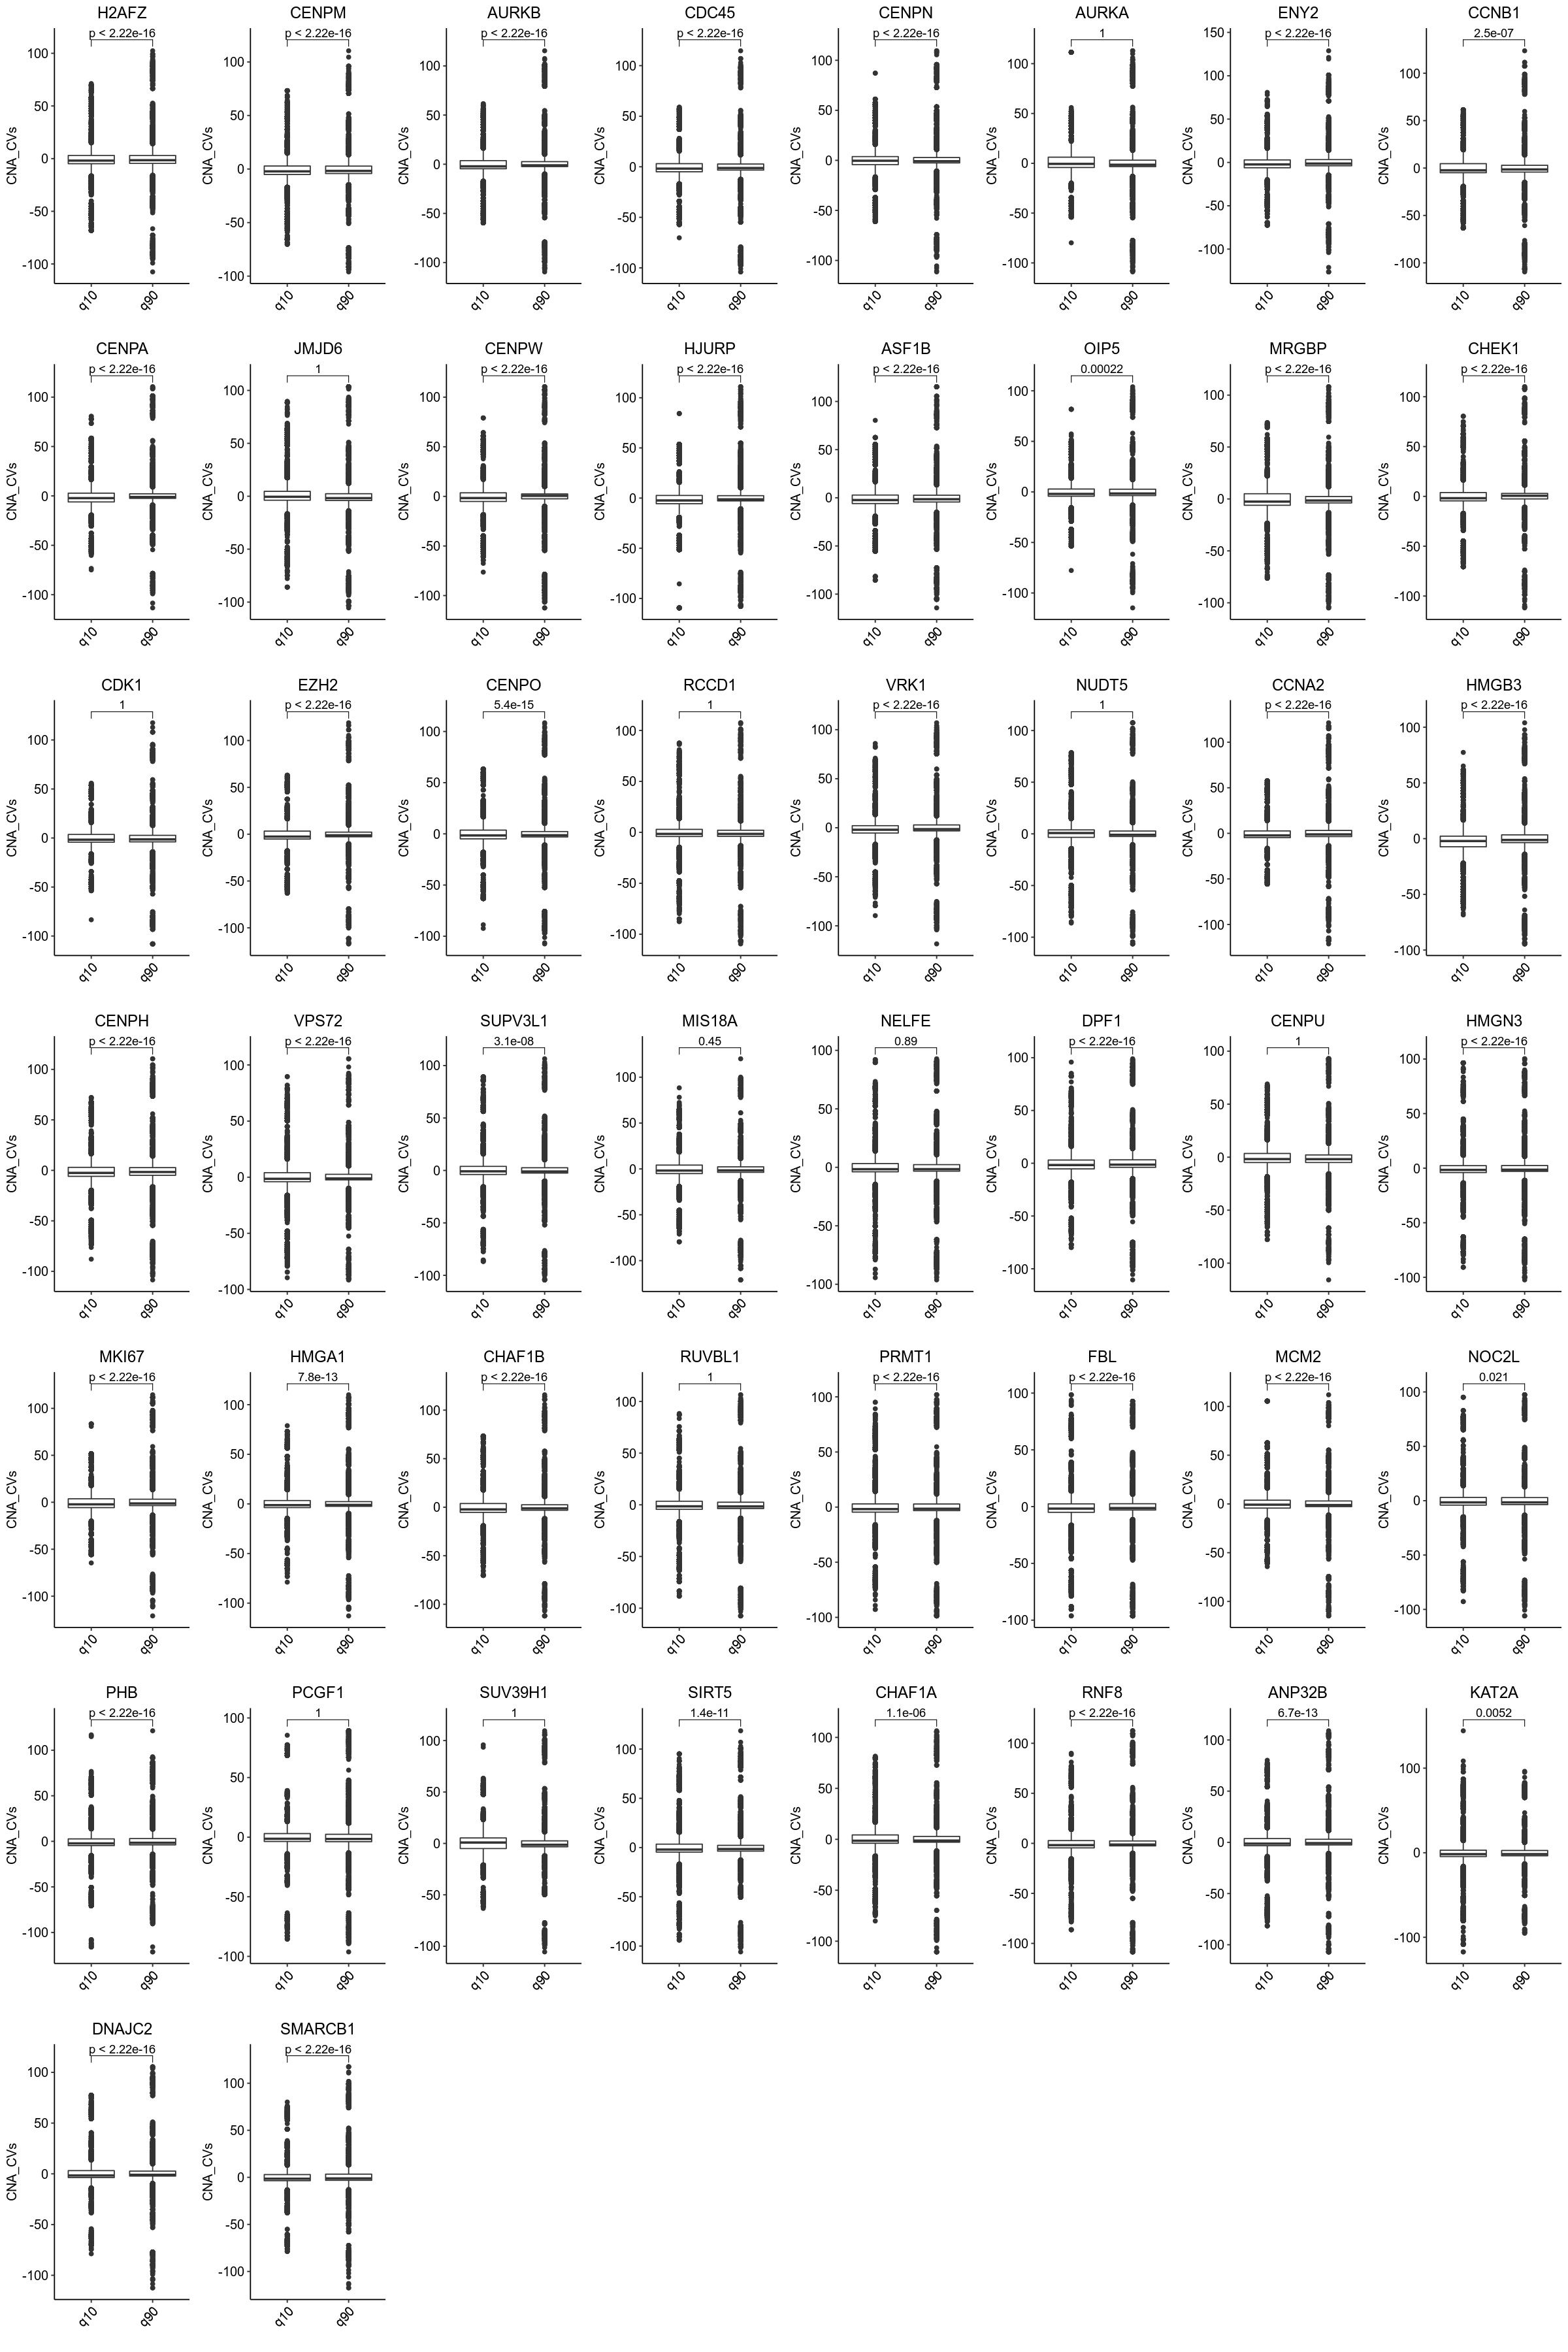

In [7]:
options(repr.plot.width = 20, repr.plot.height = 30)
ggarrange(plotlist = plots)

### Correlation of gene expression CV with CNA CV ###

In [9]:
## correlate gene expression CV q90/q10 genes ratio with CNA CV q90/q10 genes ratio
## do for all COs above
path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original/'
load(paste0(path, 'gped_clean_df_CV_ratio_q10_q90.RData'))
grouped_dataframes_list_with_CV_ratio_cleaned_q10_q90 = grouped_dataframes_list_with_CV_ratio_cleaned
names(grouped_dataframes_list_with_CV_ratio_cleaned_q10_q90) = unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned_q10_q90, '[[', 1))
q10_q90_gene_exp_CVs_list = grouped_dataframes_list_with_CV_ratio_cleaned_q10_q90[CO_genes_q10_q90] ## 3rd element for each list items is q10, 4th element is q90

q90_q10_gene_exp_CVs = lapply(q10_q90_gene_exp_CVs_list, function(x) 1/x[[3]]$CV_ratio)
names(q90_q10_gene_exp_CVs) = CO_genes_q10_q90
q90_q10_gene_exp_gene_names = q10_q90_gene_exp_CVs_list[[1]][[3]]$Hugo_Symbol

q90_q10_CNA_gene_names = as.character(CNA_data$Hugo_Symbol) ## for q90_q10_CNA_CV_ratios



In [10]:
save(q90_q10_gene_exp_CVs, q90_q10_gene_exp_gene_names, q90_q10_CNA_gene_names, q90_q10_CNA_CV_ratios, file = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/CNA_analysis/q90_q10_gene_exp_CVs_and_CNA_CVs.RData')

In [3]:
load('/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/CNA_analysis/q90_q10_gene_exp_CVs_and_CNA_CVs.RData')

In [4]:
q90_q10_genes = intersect(q90_q10_gene_exp_gene_names, q90_q10_CNA_gene_names)
q90_q10_gene_exp_CVs_ordered = lapply(q90_q10_gene_exp_CVs, function(x) x[match(q90_q10_genes, q90_q10_gene_exp_gene_names)])
q90_q10_CNA_CV_ratios_ordered = lapply(q90_q10_CNA_CV_ratios, function(x) x[match(q90_q10_genes, q90_q10_CNA_gene_names)])
CO_genes_q10_q90 = names(q90_q10_gene_exp_CVs_ordered)

In [10]:
corr_df = list()
corr_plots = list()
for (i in 1:length(CO_genes_q10_q90)) {
    corr_df[[i]] = data.frame(gene_exp_CV_ratios = q90_q10_gene_exp_CVs_ordered[[i]], CNA_CV_ratios = q90_q10_CNA_CV_ratios_ordered[[i]])
    corr_plots[[i]] = corr_df[[i]] %>% ggplot(aes(x = gene_exp_CV_ratios, y = CNA_CV_ratios)) +
    geom_smooth(method = "lm", formula = y ~ x, se = F, color = 'black') + geom_point() + xlab('Gene Exp CV q90/q10 ratios') + ylab('CNA CV q90/q10 ratios') +
    stat_cor(aes(), method = "pearson") + theme_pubr() +  
    ggtitle(CO_genes_q10_q90[i]) + #ylim(-0.32, 0.32) + xlim(-0.32, 0.32) +
    theme(plot.title = element_text(hjust = 0.5))
}
names(corr_df) = CO_genes_q10_q90

In [11]:
RNF8_corr_df = corr_df[['RNF8']]
MIS18A_corr_df = corr_df[['MIS18A']]
saveRDS(RNF8_corr_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig1/RNF8_corr_df_q10_q90.RDS')
saveRDS(MIS18A_corr_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig1/MIS18A_corr_df_q10_q90.RDS')

Warning message:
“Removed 349 rows containing non-finite values (stat_smooth).”


Warning message:
“Removed 349 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 349 rows containing missing values (geom_point).”
Warning message:
“Removed 483 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 483 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 483 rows containing missing values (geom_point).”
Warning message:
“Removed 582 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 582 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 582 rows containing missing values (geom_point).”
Warning message:
“Removed 403 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 403 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 403 rows containing missing values (geom_point).”
Warning message:
“Removed 950 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 950 rows containing non-finite values (sta

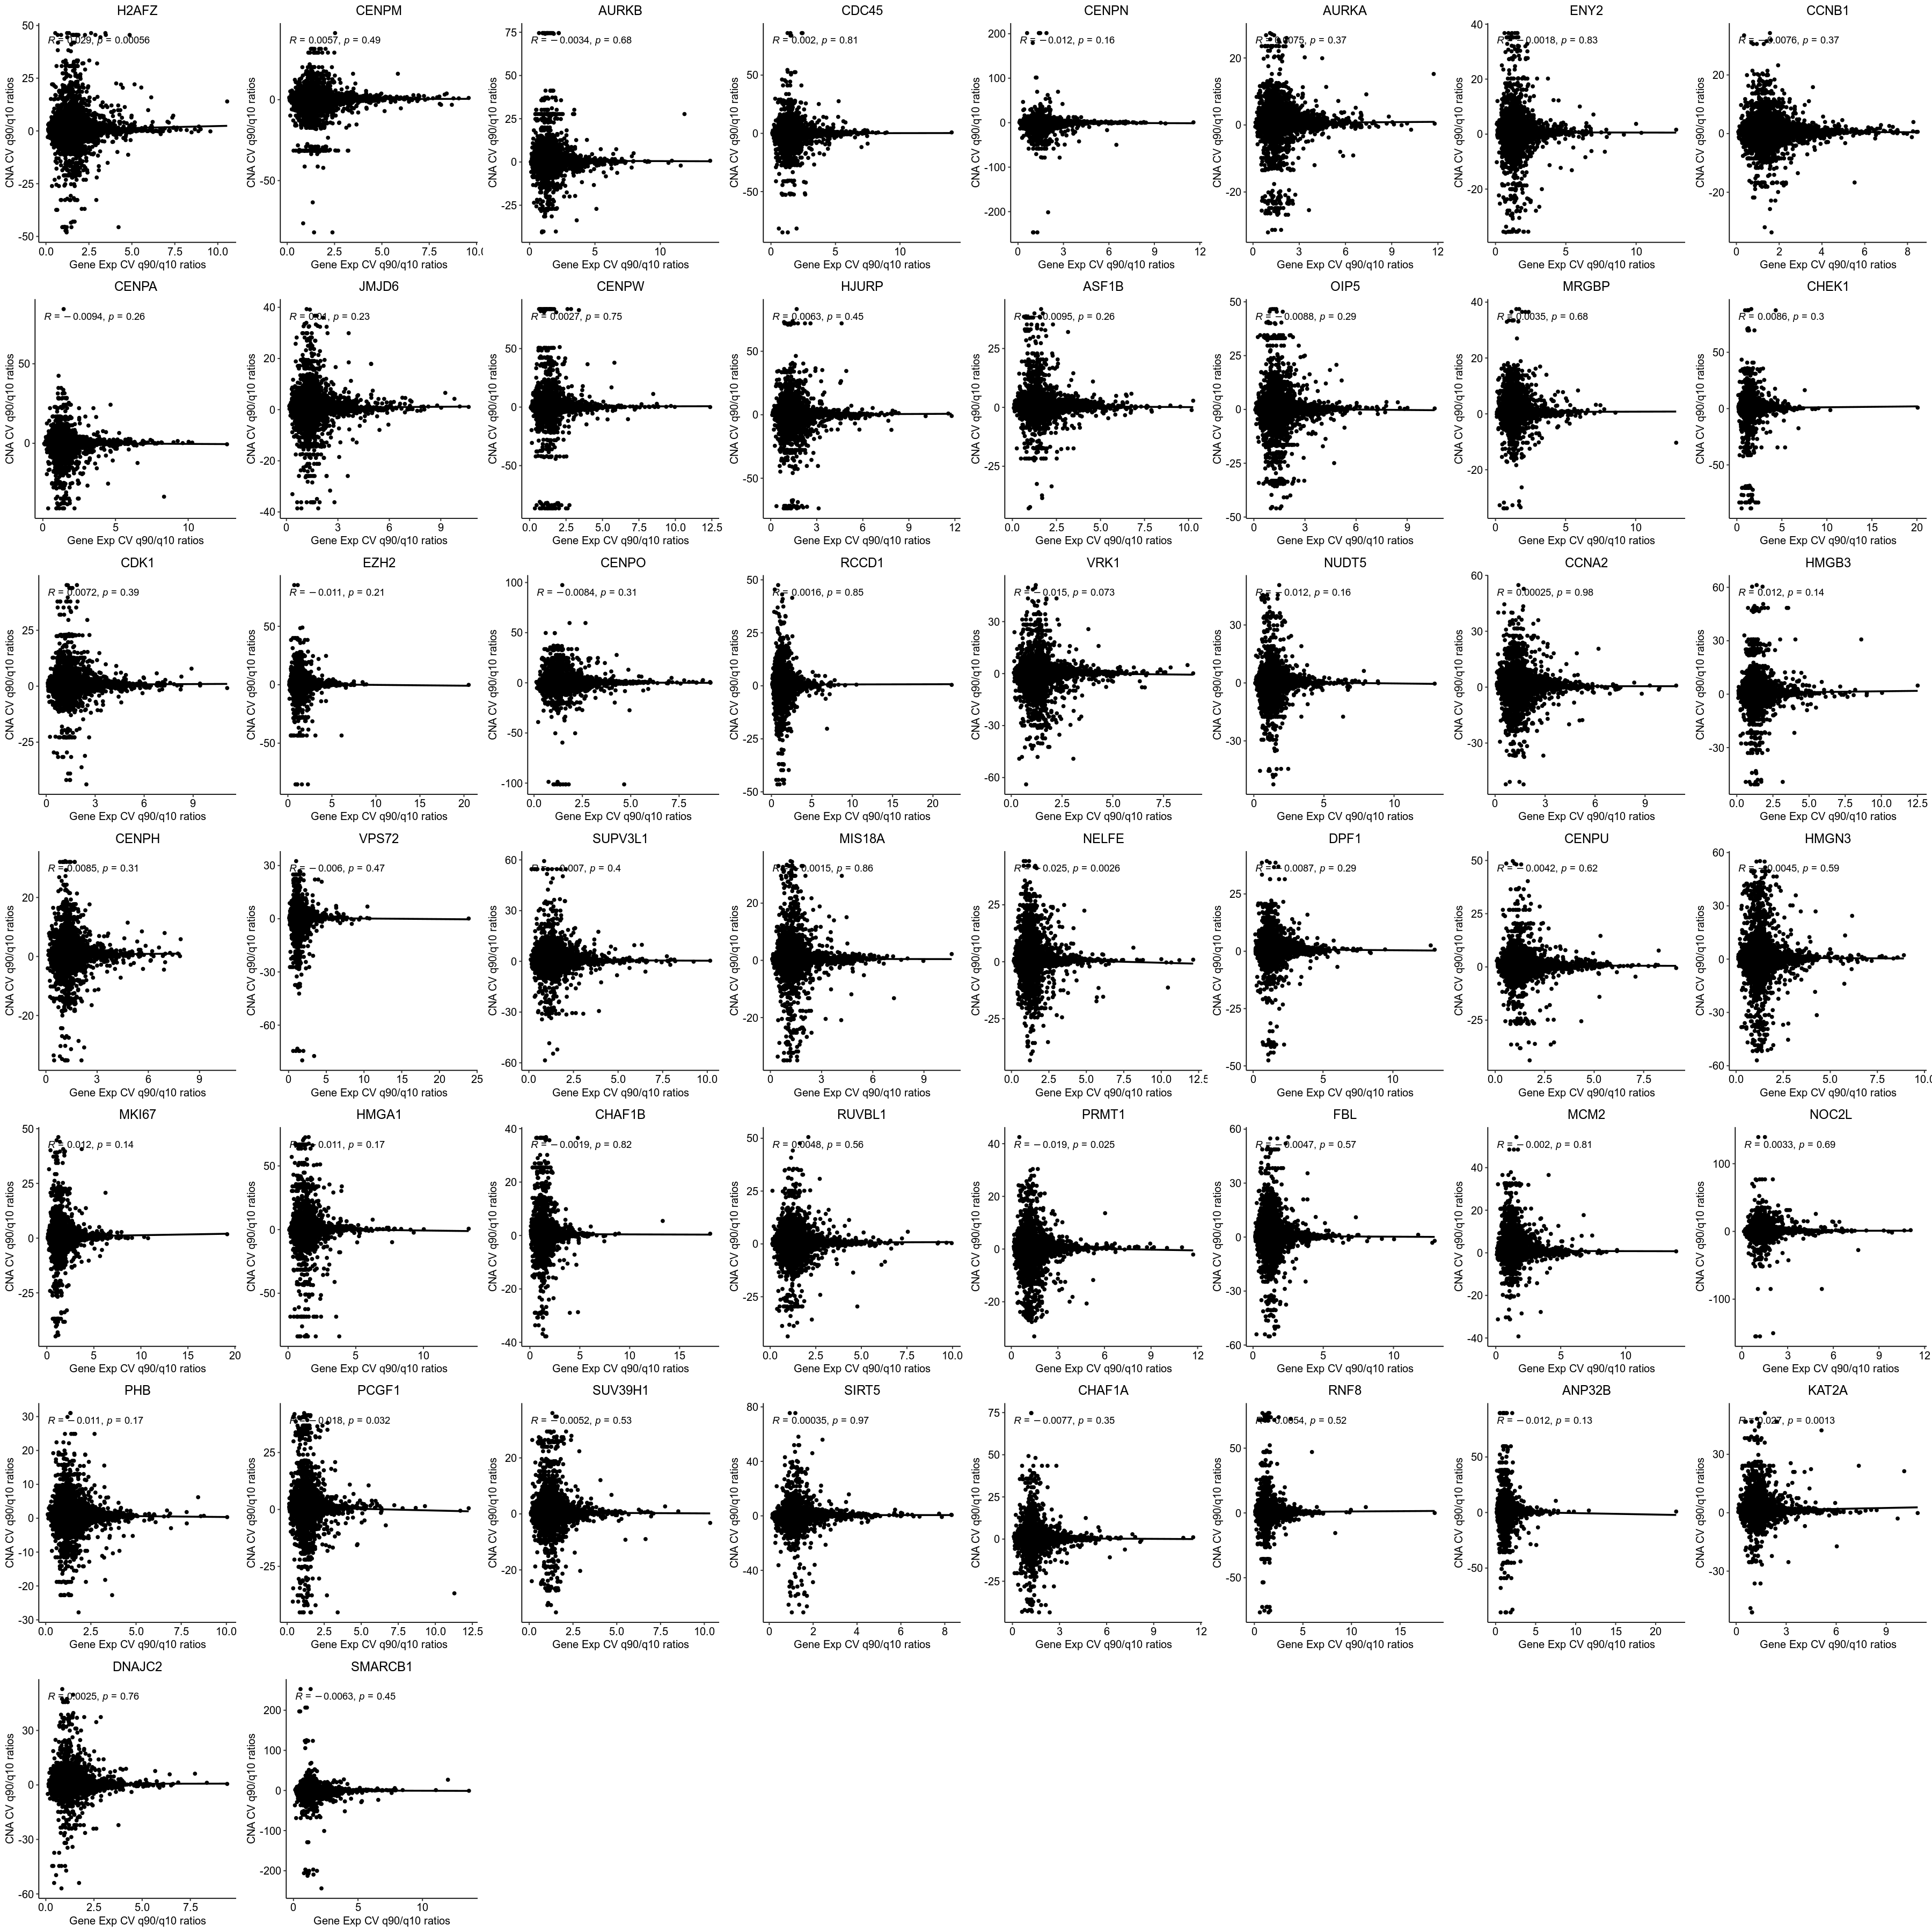

In [14]:
options(repr.plot.width = 30, repr.plot.height = 30)
ggarrange(plotlist = corr_plots)